In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt

/home/jincheng/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
## Import the data
datapath = "/home/jincheng/zillow/data/"
df_x = pd.read_csv(datapath + "properties_2016.csv")
df_y = pd.read_csv(datapath + "train_2016_v2.csv")
print(df_x.shape)
print(df_y.shape)

(90275, 3)

In [13]:
## Fill missing value with -1
## Not sure why this improve the outcome
## xgboost can handle missing values, but filling missing with -1
## essentially takes NA as a new factor level
for c in df_x.columns:
    df_x[c] = df_x[c].fillna(-1)
    if df_x[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(df_x[c].values))
        df_x[c] = lbl.transform(list(df_x[c].values))

data = df_x.merge(df_y, on='parcelid')

## Check how data looks like
print(data.head())

   parcelid  airconditioningtypeid  architecturalstyletypeid  basementsqft  \
0  17073783                     -1                        -1            -1   
1  17088994                     -1                        -1            -1   
2  17100444                     -1                        -1            -1   
3  17102429                     -1                        -1            -1   
4  17109604                     -1                        -1            -1   

   bathroomcnt  bedroomcnt  buildingclasstypeid  buildingqualitytypeid  \
0          2.5           3                   -1                     -1   
1          1.0           2                   -1                     -1   
2          2.0           3                   -1                     -1   
3          1.5           2                   -1                     -1   
4          2.5           4                   -1                     -1   

   calculatedbathnbr  decktypeid       ...         structuretaxvaluedollarcnt  \
0    

In [14]:
## Filter outliers
data = data[data.logerror > -0.4]
data = data[data.logerror < 0.418]
print(data.shape)

(88525, 60)


In [18]:
## Prepare for training
x_train = data.drop(['parcelid','logerror','transactiondate'], axis=1)
x_test = df_x.drop(['parcelid'],axis=1)
y_train = data['logerror'].values.astype(np.float32)

Index([u'airconditioningtypeid', u'architecturalstyletypeid', u'basementsqft',
       u'bathroomcnt', u'bedroomcnt', u'buildingclasstypeid',
       u'buildingqualitytypeid', u'calculatedbathnbr', u'decktypeid',
       u'finishedfloor1squarefeet', u'calculatedfinishedsquarefeet',
       u'finishedsquarefeet12', u'finishedsquarefeet13',
       u'finishedsquarefeet15', u'finishedsquarefeet50',
       u'finishedsquarefeet6', u'fips', u'fireplacecnt', u'fullbathcnt',
       u'garagecarcnt', u'garagetotalsqft', u'hashottuborspa',
       u'heatingorsystemtypeid', u'latitude', u'longitude',
       u'lotsizesquarefeet', u'poolcnt', u'poolsizesum', u'pooltypeid10',
       u'pooltypeid2', u'pooltypeid7', u'propertycountylandusecode',
       u'propertylandusetypeid', u'propertyzoningdesc',
       u'rawcensustractandblock', u'regionidcity', u'regionidcounty',
       u'regionidneighborhood', u'regionidzip', u'roomcnt', u'storytypeid',
       u'threequarterbathnbr', u'typeconstructiontypeid', u'unitc

In [ ]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

In [46]:
xgb_params = {
    'eta': 0.037,
    'max_depth': 5,
    'subsample': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'lambda': 0.8, ## L2 regularization
    'alpha': 0.4,  ## L1 regularization
    'base_score': 0,
    'slient': 1
}

logerror_mean = np.mean(data['logerror'])
print("benchmarking testing MAE: " + str(np.mean(np.abs(data['logerror'] - logerror_mean))))

benchmarking testing MAE: 0.0532990696687


In [47]:
cv_result = xgb.cv(xgb_params, dtrain,
                  nfold = 5,
                  num_boost_round = 500,
                  early_stopping_rounds = 20,
                  verbose_eval=10,
                  show_stdv=True)

[0]	train-mae:0.0534846+9.9508e-05	test-mae:0.0534896+0.00040076
[10]	train-mae:0.0530796+9.3485e-05	test-mae:0.0531266+0.000395208
[20]	train-mae:0.0528554+8.45804e-05	test-mae:0.052943+0.000390731
[30]	train-mae:0.0527298+8.14847e-05	test-mae:0.0528546+0.000385366
[40]	train-mae:0.0526436+8.27493e-05	test-mae:0.0528006+0.000375541
[50]	train-mae:0.052586+8.31144e-05	test-mae:0.0527738+0.00037469
[60]	train-mae:0.052535+8.44772e-05	test-mae:0.0527556+0.000374857
[70]	train-mae:0.0524916+8.60339e-05	test-mae:0.0527428+0.000371666
[80]	train-mae:0.052451+8.70448e-05	test-mae:0.052731+0.000373236
[90]	train-mae:0.052415+8.9851e-05	test-mae:0.0527222+0.000372
[100]	train-mae:0.0523802+9.05481e-05	test-mae:0.0527172+0.000370526
[110]	train-mae:0.0523494+9.27353e-05	test-mae:0.052713+0.000368724
[120]	train-mae:0.0523164+9.23355e-05	test-mae:0.0527068+0.000371699
[130]	train-mae:0.052288+9.19587e-05	test-mae:0.052702+0.000374236
[140]	train-mae:0.0522576+9.36645e-05	test-mae:0.0526976+0.000

In [49]:
print("Optimal number of trees is: " + str(len(cv_result)))
fit = xgb.train(xgb_params, dtrain, num_boost_round=len(cv_result))

195


In [50]:
## Make prediction
y_pred = fit.predict(dtest)

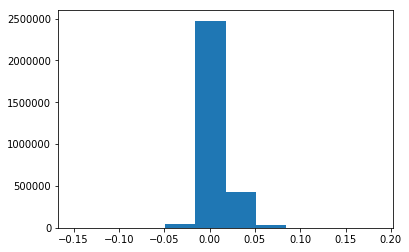

In [51]:
## Check distribution of prediction
plt.hist(y_pred)
plt.show()

In [52]:
## Format for output
print( "\nFormat for output" )
output = pd.DataFrame({'Parcelid': df_x['parcelid'].astype(np.int32),
                      '201610': y_pred,
                      '201611': y_pred,
                      '201612': y_pred,
                      '201710': y_pred,
                      '201711': y_pred,
                      '201712': y_pred})

cols = output.columns.tolist()
cols = cols[-1:] + cols[:-1]
output = output[cols]

In [54]:
print( "\nWriting results to disk ..." )
output.to_csv("../result/xgboost_py1.csv", index=False)


Writing results to disk ...
